In [1]:
library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ggplot2)
library(pheatmap)
library(viridis)
library(RColorBrewer)
set.seed(3452)

setwd("/lustre/groups/ies/projects/hamperl_lab/elizabeth.marquezgom/scMultiomicsCourse")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading

# Homework assignment

### 1. Do QC on the dataset that was assigned to you: how many "bad" cells do you have? 

### Load data

In [2]:
## Get gene annotations for hg38 genome
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevels(annotation) <- paste0('chr', seqlevels(annotation))
genome(annotation) <- 'hg38'

## Load objects
counts_raw <- Read10X_h5(filename = "data/human_brain_3k_raw_feature_bc_matrix.h5")
counts_filtered <- Read10X_h5(filename = "data/human_brain_3k_filtered_feature_bc_matrix.h5")

## Load metadata
metadata <- read.csv(
  file = "data/human_brain_3k_per_barcode_metrics.csv",
  header = TRUE,
  row.names = 1
)

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [ ]:
## Sampling cells for homework
cell_subset <- readRDS("data/p2_homeworkCells_byCluster.RDS")

# Set seed for reproducibility with selected cells
set.seed(120701)
my_cells <- sample(x = cell_subset, 
                size = ceiling(length(cell_subset)*0.7), 
                replace = FALSE)

cell_subset <- my_cells
length(cell_subset)

[1] 2577

In [7]:
## Create a Seurat object containing the RNA adata
multi_object <- CreateSeuratObject(
  counts = counts_raw$`Gene Expression`[,cell_subset], 
  assay = "RNA",
  meta.data = metadata, 
  project = "Brain",  
  min.features = 1,
  min.cells = 1
)

## Create ATAC assay and add it to the object
multi_object[["ATAC"]] <- CreateChromatinAssay(
  counts = counts_raw$Peaks[,Cells(multi_object[['RNA']])], # subset the matrix to keep only cells that are in the RNA object
  sep = c(":", "-"),
  fragments = "data/human_brain_3k_atac_fragments.tsv.gz",
  annotation = annotation,
  genome='hg38', 
  validate.fragments = T,
  min.features = 1,
  min.cells = 1
)

Computing hash



### Quality control - RNA-seq assay

In [8]:
## Compute percentage of mitochondrial reads
DefaultAssay(multi_object) <- "RNA"

multi_object[["percent.mt"]] <- PercentageFeatureSet(multi_object, pattern = "^MT-")
head(multi_object[["percent.mt"]])


,percent.mt
,<dbl>
ACCTCACTCAAGTGTC-1,0.15278839
CTCATCATCAAACACC-1,0.07538636
ATTGTGATCCACCCTG-1,0.00000000
GCGTTTCTCACGCCAA-1,0.00000000
TGCGATTAGTTAGACC-1,0.23041475
TCCGCCATCGTTACAA-1,0.00000000


Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message:
"The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Warning message:
"`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."


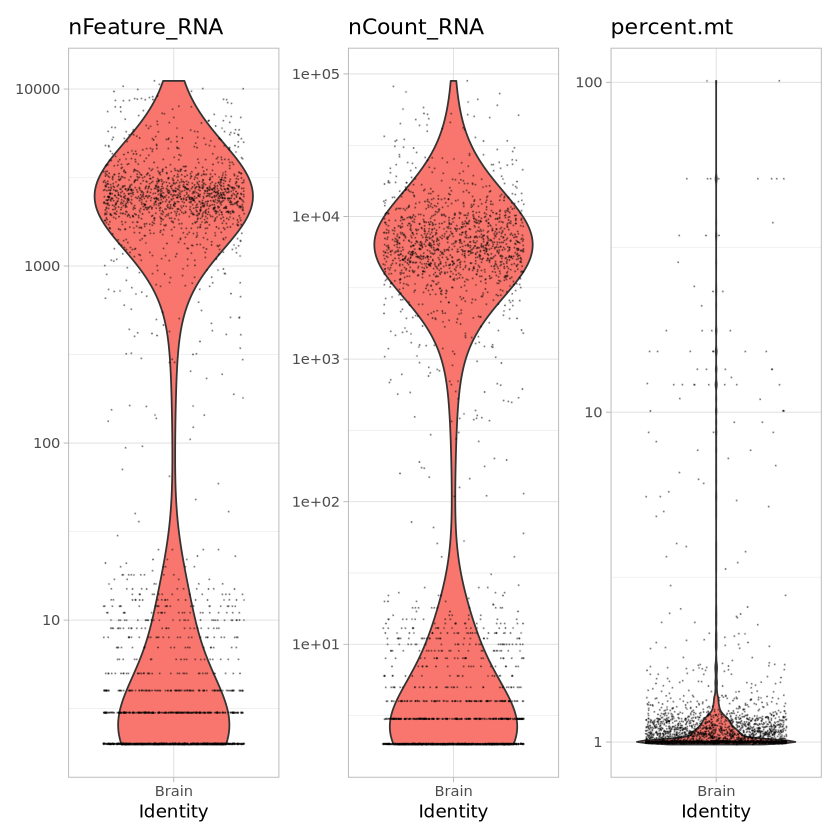

In [ ]:
## Computing QC plots
VlnPlot(
  object = multi_object,
  features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),  
  pt.size = 0.01, alpha = 0.3, ncol=3, log = TRUE
) & theme_light() & NoLegend() 

The plots for *features* and *UMIs* show a bimodal distribution, indicating two groups, high quality and low quality cells. 

As for the *mitochondrial reads*, there is a low count of cells that present a high presence of them.

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."


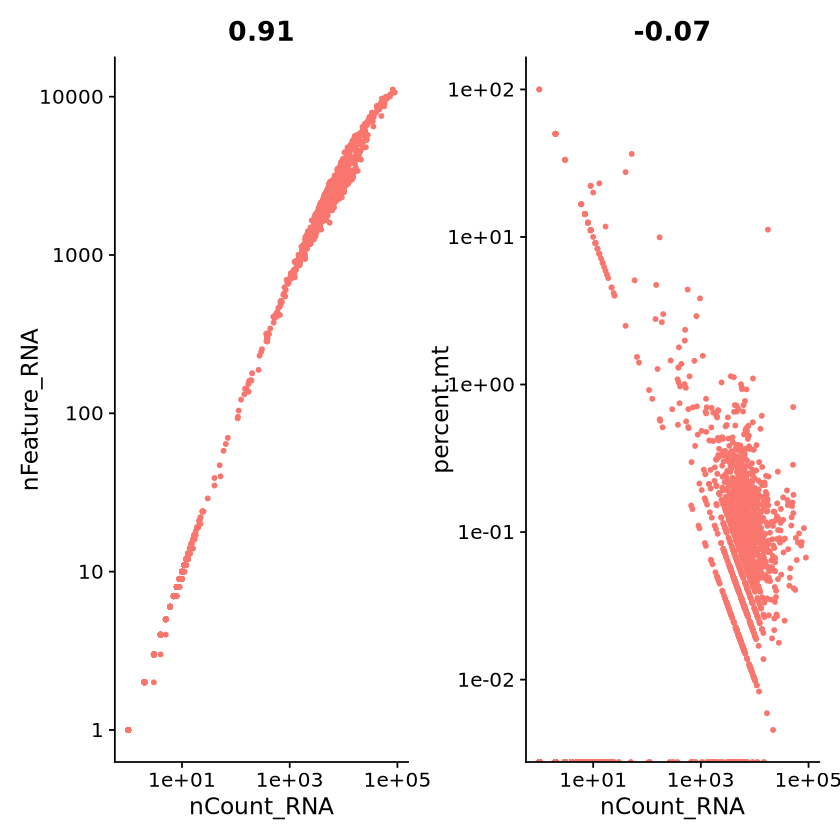

In [10]:
## Correlations between QC metrics
plot1 <- FeatureScatter(multi_object, feature1 = "nCount_RNA", feature2 = "nFeature_RNA", log=TRUE) + NoLegend()
plot2 <- FeatureScatter(multi_object, feature1 = "nCount_RNA", feature2 = "percent.mt", log=TRUE) + NoLegend() ## It might be correlated but the correlation coefficient is very low because of the 0's
plot1 + plot2

As expected, *features* and *UMIs* are linearly correlated, and is good to see a higher proportion of cells with high amount of molecules and high presence of genes.

The correlation of the *UMIs* along with the presence of *mitochondrial reads* is interferred by the presence of 0's in the counts, which also make the correlation coefficient very low.

### Quality control - ATAC-seq assay

In [11]:
DefaultAssay(multi_object) <- "ATAC"

## Compute nucleosome signal score (per cell) - Periodic pattern of nucleosome positioning
multi_object <- NucleosomeSignal(object = multi_object)

## Compute TSS enrichment score (per cell) - Expected enrichment of reads at transcription start sites compared to regions out of the TSS (serves as sanity check)
multi_object <- TSSEnrichment(object = multi_object, fast = FALSE) # the long version doesn't work

## Compute the fraction of reads in peaks (per cell)
multi_object$pct_reads_in_peaks <- multi_object$atac_peak_region_fragments / multi_object$atac_fragments * 100 

## Compute the fraction of reads overlapping ENCODE blacklist regions (per cell)
multi_object$blacklist_fraction <- FractionCountsInRegion(
  object = multi_object,
  assay = 'ATAC',
  regions = blacklist_hg38 
)

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



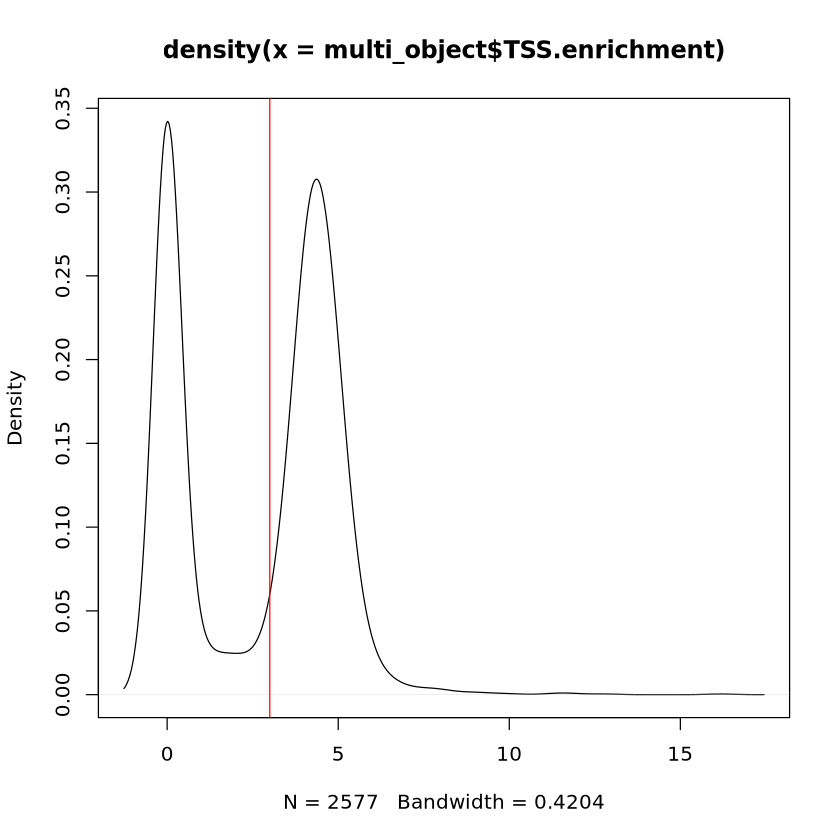

In [12]:
## Evaluate TSS enrichment
par(bg = "white")  # to set white packground for the plot
plot(density(multi_object$TSS.enrichment))
abline(v=3, col="red")

Distribution shows a bimodal behavior, which is expected. The default threshold of 3 cuts at the beginning of the second peak, splitting both groups at the end of the valley.

In [13]:
summary(multi_object$TSS.enrichment)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000000  0.002708  3.758242  2.707397  4.514049 16.183816 

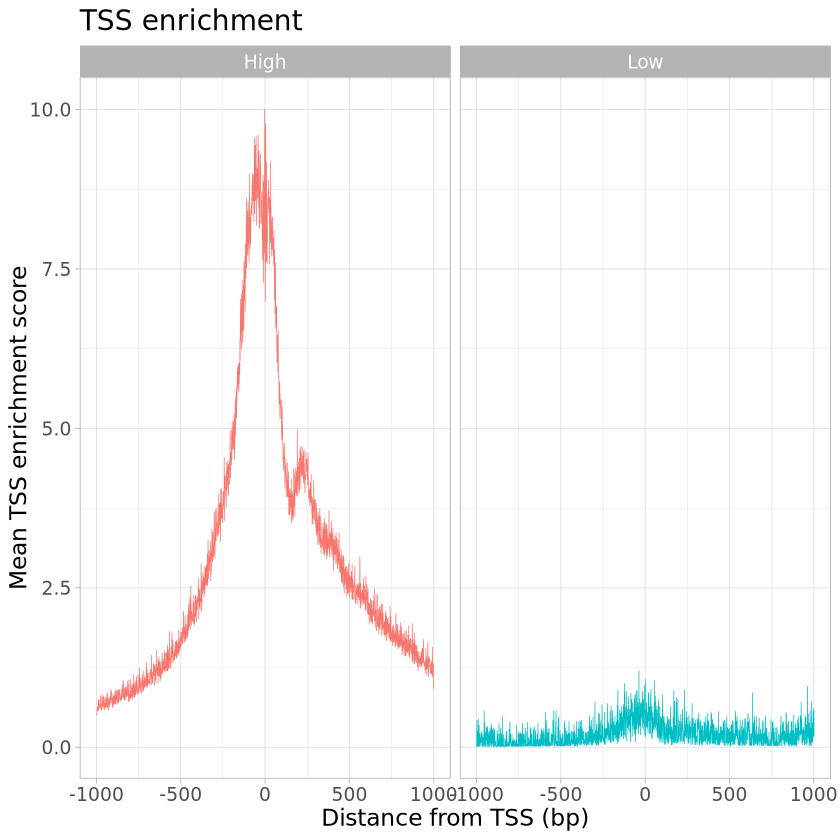

In [ ]:
## Classify TSS by threshold and look at trends
multi_object$high.tss <- ifelse(multi_object$TSS.enrichment > 3, 'High', 'Low')
TSSPlot(multi_object, group.by = 'high.tss') + 
  theme_light() + theme(text=element_text(size=14)) + NoLegend() 

Plots show a good behavior in the classifications, where `high` shows a big peak followed by a small shoulder dowstream of the TSS. `Low` class shows a very low peak in comparison, indicating a correct classification.

In [15]:
table(multi_object$high.tss)


High  Low 
1482 1095 

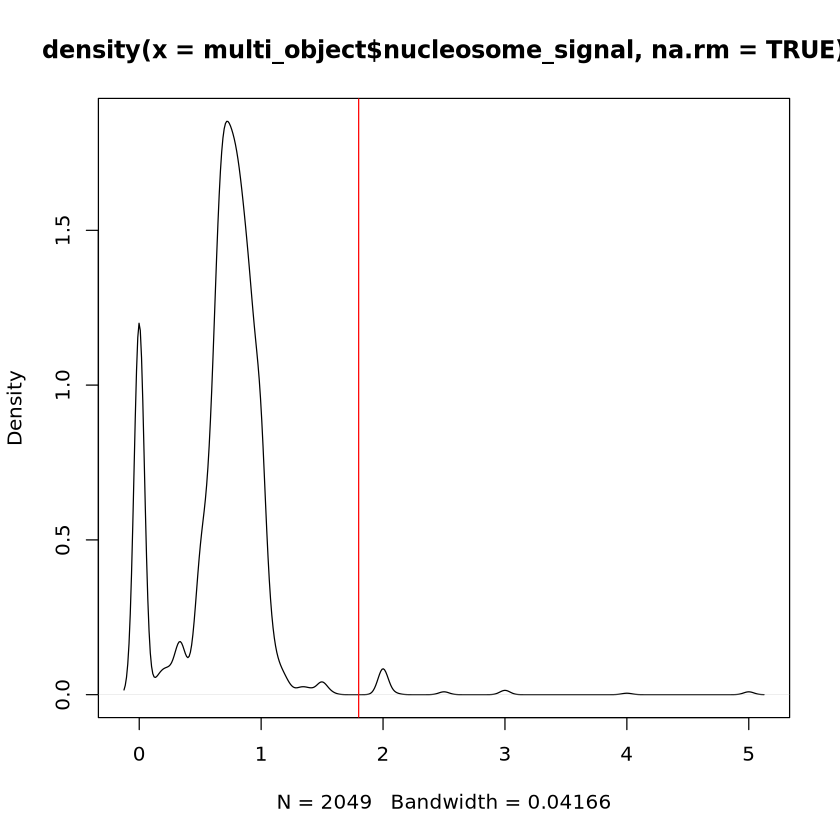

In [16]:
## Evaluate nucleosome signal
par(bg = "white")  # to set white packground for the plot
plot(density(multi_object$nucleosome_signal, na.rm=TRUE))
abline(v=1.8, col="red")

Warning message:
"Removed 725 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`)."


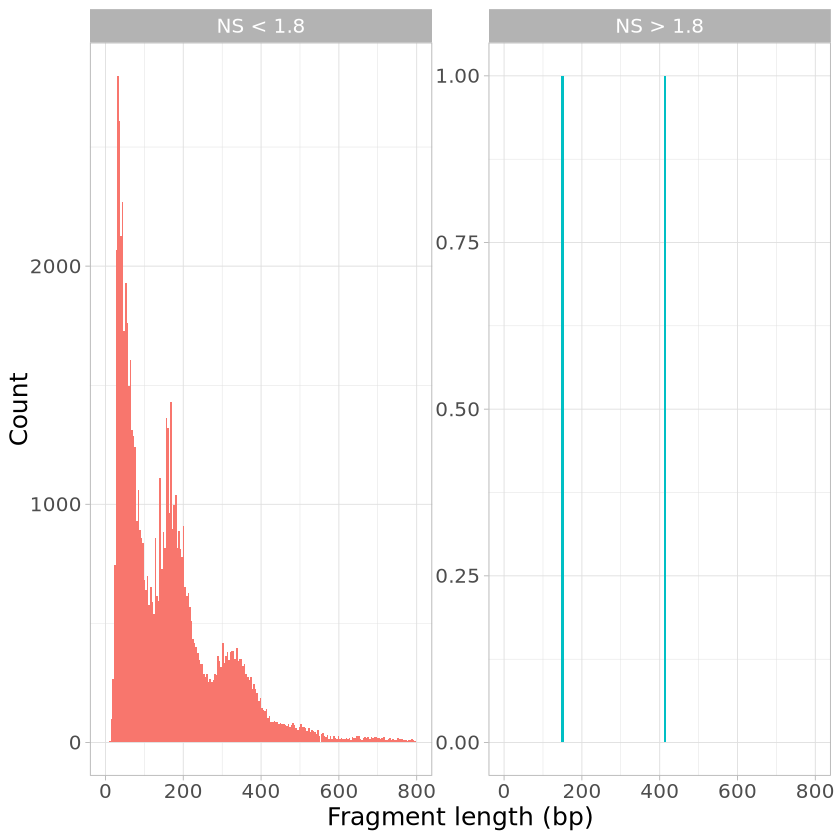

In [17]:
multi_object$nucleosome_group <- ifelse(multi_object$nucleosome_signal > 1.8, 'NS > 1.8', 'NS < 1.8')
FragmentHistogram(object = multi_object, group.by = 'nucleosome_group')+
    theme_light() + theme(text=element_text(size=15)) + NoLegend()

The observed frequency of peaks fits well the expected behavior of an ATAC-seq experiment. In addition, there are very low amount of reads that do not pass the threshold, indicating good quality of data.

In [18]:
table(multi_object$nucleosome_group)


NS < 1.8 NS > 1.8 
    1926      123 

### Distribution pre-filtering

Warning message:
"Removed 624 rows containing non-finite outside the scale range
(`stat_ydensity()`)."
Warning message:
"Removed 528 rows containing missing values or values outside the scale range
(`geom_point()`)."


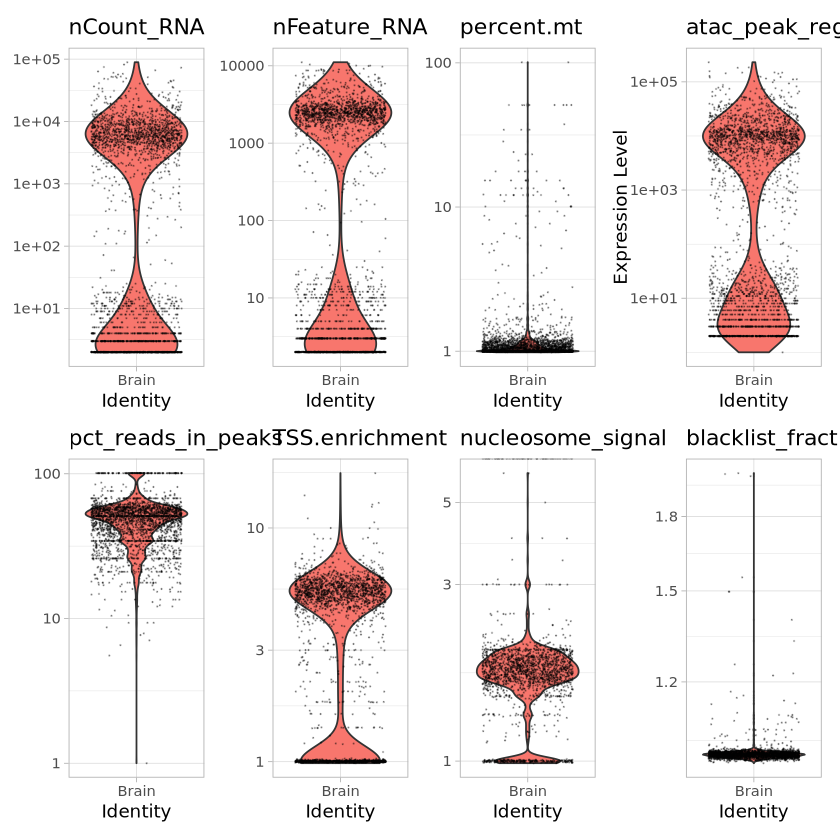

In [26]:
## Violin of QC metrics
VlnPlot(
  object = multi_object,
  features = c('nCount_RNA','nFeature_RNA', 'percent.mt', 'atac_peak_region_fragments',
               'pct_reads_in_peaks', 'TSS.enrichment', 'nucleosome_signal', 'blacklist_fraction'),  
  pt.size = 0.01, alpha = 0.3, ncol=4, log = TRUE
) & theme_light() & NoLegend() 

In general we still see two population of cells (high and low quality), along with low fractions of blacklisted regions that could bias the study. Is also good to see than most of the cells conserve an accepted score of nucleosome signal

Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


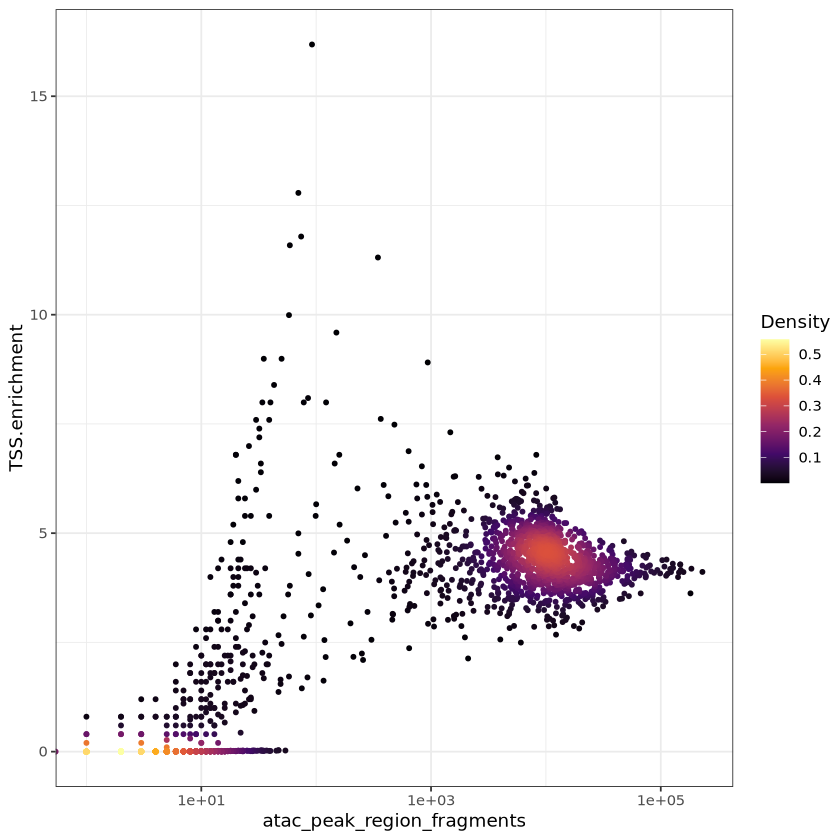

In [21]:
DensityScatter(multi_object, x= 'atac_peak_region_fragments', y = 'TSS.enrichment', log_x = TRUE, quantiles = FALSE)

The density scatter plot shows to main populations, consistent with the previous observations.

### Correlation between ATAC-seq and RNA-seq quality metrics

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."


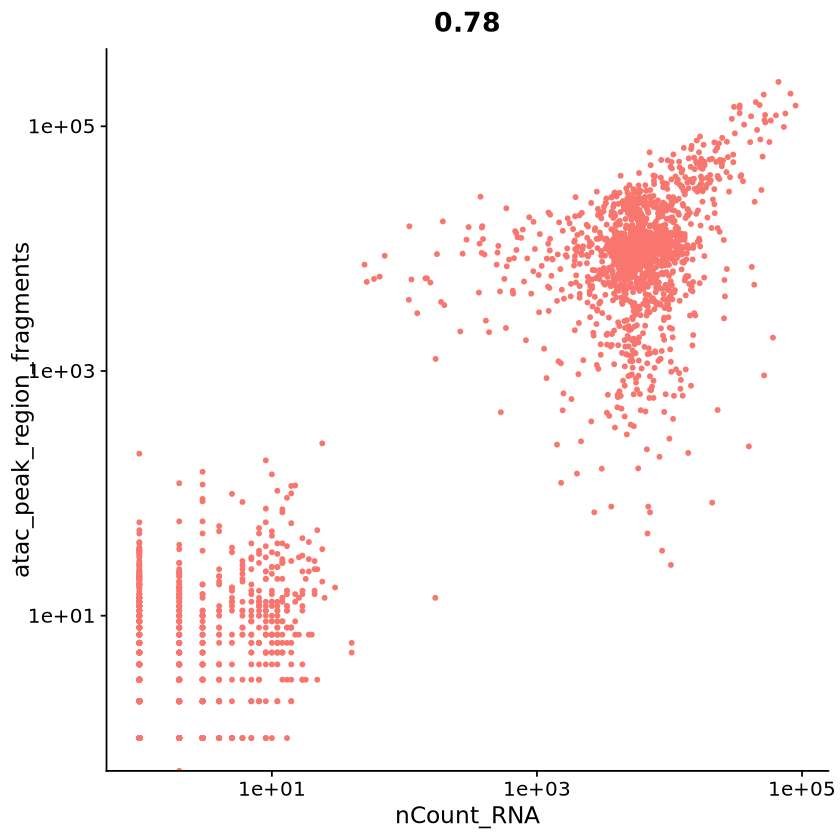

In [22]:
FeatureScatter(
  object = multi_object,
  feature1 = "nCount_RNA", 
  feature2 = "atac_peak_region_fragments",
  log=TRUE
) + NoLegend()

The scatter plot shows a correlation between UMI counts and peak fragments, meaning that cells that fail for one assay will also fail for the other. Nevertheles, as expected, there are more cells having a lower performance for ATAC-seq in comparison to RNA-seq

### Bad quality cells

In [23]:
## Filter out cells that are outliers for these QC metrics
mObj_filtered <- subset(
  x = multi_object,
  subset = nCount_RNA > 500 & nCount_RNA < 75000 & ## UMIs (molecules) per cell tagged, this filter is standard, and we are avoiding multiplets
    percent.mt < 5 &
    atac_peak_region_fragments > 1500 & atac_peak_region_fragments < 75000 &
    pct_reads_in_peaks > 15 &       
    blacklist_fraction < 0.025 &
    nucleosome_signal < 2 &  
    TSS.enrichment > 2 & TSS.enrichment < 8
)
mObj_filtered

An object of class Seurat 
161836 features across 1275 samples within 2 assays 
Active assay: ATAC (134012 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: RNA

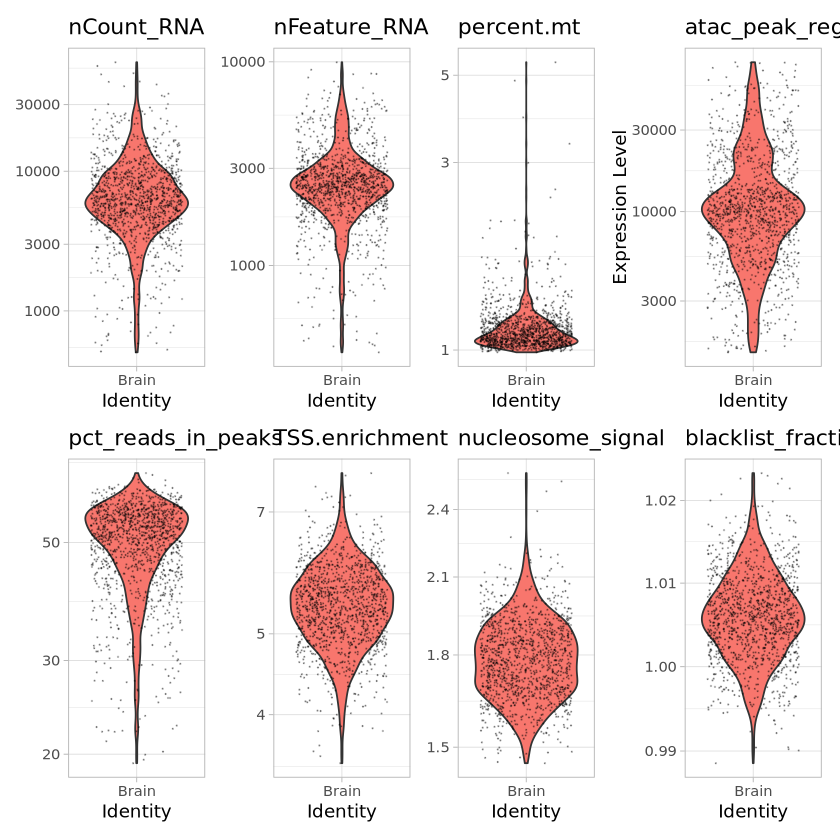

In [27]:
## Distribution post filtering
VlnPlot(
  object = mObj_filtered,
  features = c('nCount_RNA','nFeature_RNA', 'percent.mt', 'atac_peak_region_fragments',
               'pct_reads_in_peaks', 'TSS.enrichment', 'nucleosome_signal', 'blacklist_fraction'),  
  pt.size = 0.01, alpha = 0.3, ncol=4, log = TRUE
) & theme_light() & NoLegend() 

After filtering, distributions show a more homogenous behavior in the dataset, which should correspond to high quality cells.

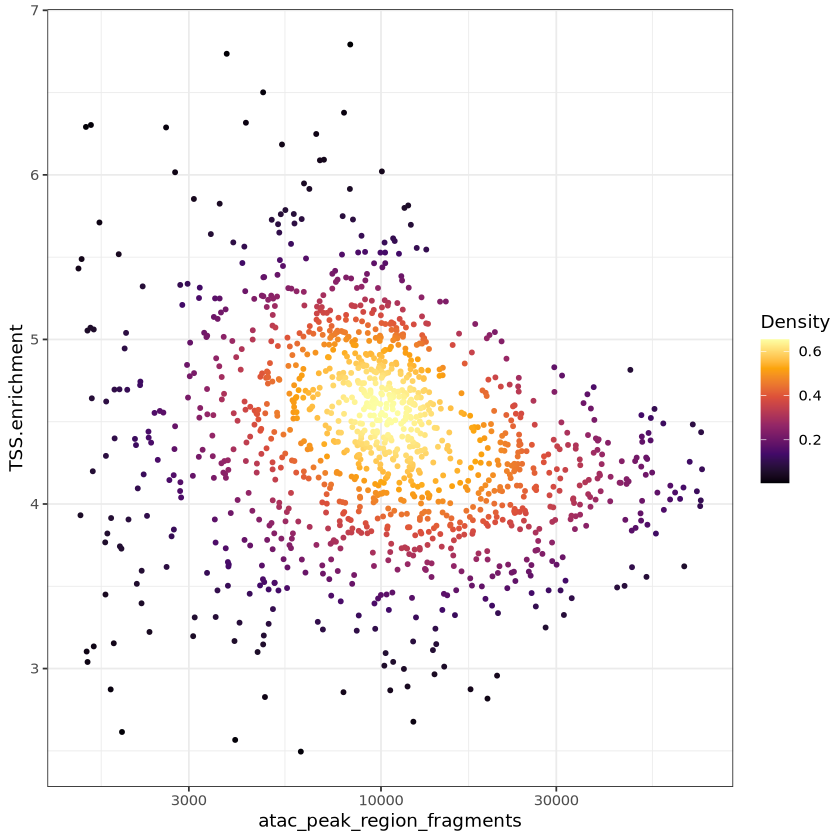

In [28]:
DensityScatter(mObj_filtered, x= 'atac_peak_region_fragments', y = 'TSS.enrichment', log_x = TRUE, quantiles = FALSE)

The scatter plot shows the lost of the low quality cell population with low amount of fragments and TSS enrichment

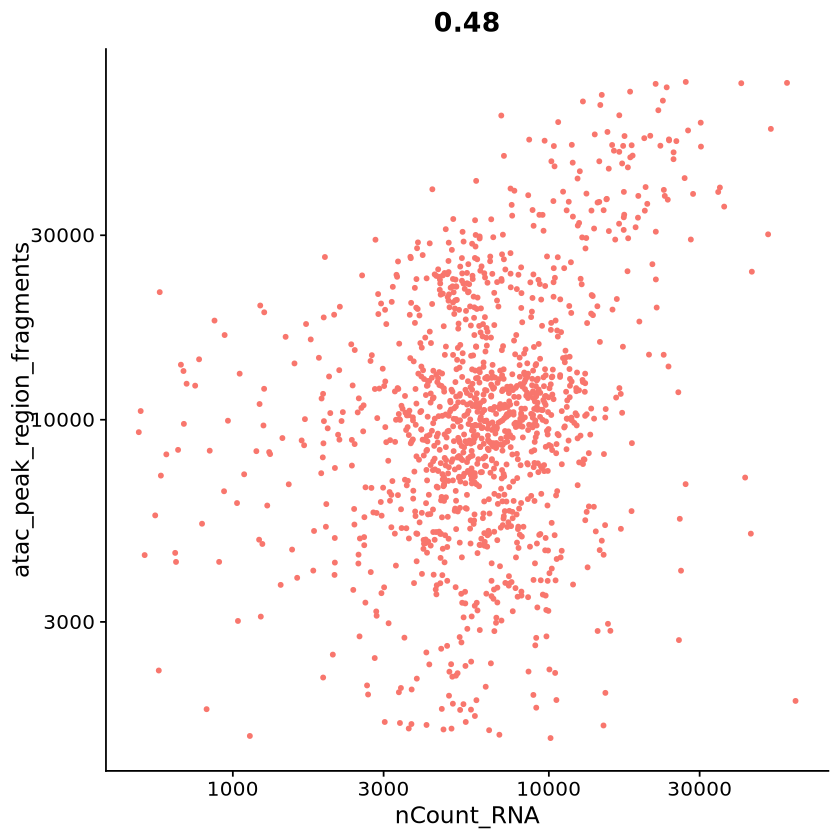

In [29]:
## Correlation between RNA and ATAC assays
FeatureScatter(
  object = mObj_filtered,
  feature1 = "nCount_RNA", 
  feature2 = "atac_peak_region_fragments",
  log=TRUE
) + NoLegend()

The filters got rid of the low quality cells, but the correlation between assays seems to be more dispersed, having cells that perfom better for one assay than the other.

In [72]:
## Get number of cells that passed the QC
cat("Full set of cells: ", length(Cells(multi_object)), "\n")
cat("Filtered set of cells: ", length(Cells(mObj_filtered)), "\n")
cat("Number of bad quality cells: ", length(Cells(multi_object)) - length(Cells(mObj_filtered)))

Full set of cells:  2577 
Filtered set of cells:  1275 
Number of bad quality cells:  1302

### 2. How many fail the RNA-seq criteria? How many fail the ATAC-seq criteria? Make a VennDiagram

In [47]:
## RNA QC
rna_filtered <- subset(
  x = multi_object,
  subset = nCount_RNA > 500 & nCount_RNA < 75000 &
    percent.mt < 5
)
rna_filtered

An object of class Seurat 
161836 features across 1406 samples within 2 assays 
Active assay: ATAC (134012 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: RNA

In [48]:
## Filter out cells that are outliers for these QC metrics
atac_filtered <- subset(
  x = multi_object,
  subset = atac_peak_region_fragments > 1500 & atac_peak_region_fragments < 75000 &
    pct_reads_in_peaks > 15 &       
    blacklist_fraction < 0.025 &
    nucleosome_signal < 2 &  
    TSS.enrichment > 2 & TSS.enrichment < 8
)
atac_filtered

An object of class Seurat 
161836 features across 1307 samples within 2 assays 
Active assay: ATAC (134012 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: RNA

In [68]:
library(VennDiagram)
cells_diff <- list(
  RNA = Cells(rna_filtered),
  ATAC = Cells(atac_filtered),
  Filtered = Cells(mObj_filtered),
  Full = Cells(multi_object)
)

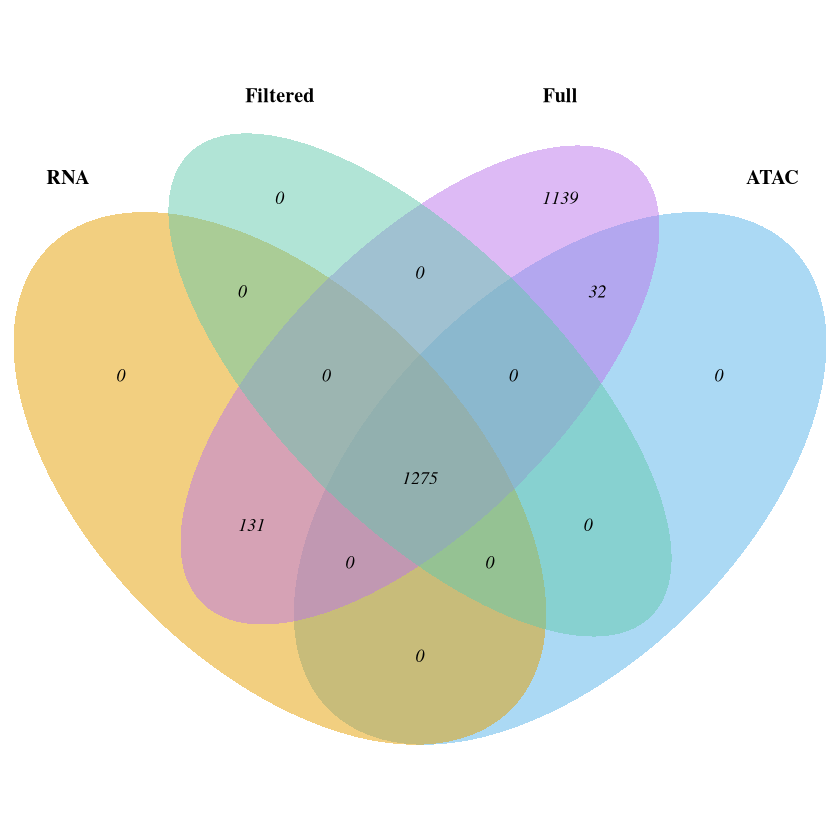

In [73]:
# Helper function to display Venn diagram
display_venn <- function(x, ...){
  grid.newpage()
  venn_object <- venn.diagram(x, filename = NULL, ...)
  grid.draw(venn_object)
}

display_venn(cells_diff, 
            # Circles
            lwd = 2,
            lty = 'blank',
            fill = c("#E69F00", "#56B4E9", "#62c9ae", "#bc74ec"), 
            # Numbers
            cex = .9,
            fontface = "italic",
            # Set names
            cat.cex = 1,
            cat.fontface = "bold",
            cat.default.pos = "outer")

### 3. Which methods are available in the "FindTopFeatures" function to select variable genes?

In [51]:
?FindTopFeatures

FindTopFeatures             package:Signac             R Documentation

_F_i_n_d _m_o_s_t _f_r_e_q_u_e_n_t_l_y _o_b_s_e_r_v_e_d _f_e_a_t_u_r_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Find top features for a given assay based on total number of
     counts for the feature. Can specify a minimum cell count, or a
     lower percentile bound to determine the set of variable features.
     Running this function will store the total counts and percentile
     rank for each feature in the feature metadata for the assay. To
     only compute the feature metadata, without changing the variable
     features for the assay, set 'min.cutoff=NA'.

_U_s_a_g_e:

     FindTopFeatures(object, ...)
     
     ## Default S3 method:
     FindTopFeatures(object, assay = NULL, min.cutoff = "q5", verbose = TRUE, ...)
     
     ## S3 method for class 'Assay'
     FindTopFeatures(object, assay = NULL, min.cutoff = "q5", verbose = TRUE, ...)
     
     ## S3 method fo

### 4. Select top 2000 variable genes with all the methods alternative to "vst" (the one we used during the lecture) and make a Venn Diagram to show the overlap between the sets of highly variable genes obtained with the different methods

### 5. Generate CoveragePlot() using the genes that you plotted in the previous homework